# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import glob
import os
import spacy
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from src.utils import color_func, get_mask, search

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [5]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df.head()


(20725, 3)
(18327, 3)


,title,subreddit,body
0,Self Help and Self Care Resources,ptsd,Unfortunately this is a small subreddit and as...
1,Survey thread,ptsd,If you have a survey you would like to share w...
2,"PTSD never getting better, don’t want to be al...",ptsd,Made a throwaway account for this obviously.\n...
3,I can’t be bothered with people anymore,ptsd,Why do I have to remind people all the time th...
4,I can't stop peeing my pants,ptsd,This is incredibly embarrassing but I am diagn...


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

In [6]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",

}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()

,title,subreddit,body,problem
0,Self Help and Self Care Resources,ptsd,Unfortunately this is a small subreddit and as...,PTSD
1,Survey thread,ptsd,If you have a survey you would like to share w...,PTSD
2,"PTSD never getting better, don’t want to be al...",ptsd,Made a throwaway account for this obviously.\n...,PTSD
3,I can’t be bothered with people anymore,ptsd,Why do I have to remind people all the time th...,PTSD
4,I can't stop peeing my pants,ptsd,This is incredibly embarrassing but I am diagn...,PTSD


### Text Cleaning and Processing
- Remove emoticons and non-text characters
- Remove excess newline and spacing characters added for emphasis (e.g., poetry paragraphing)
- Remove hyperlinks and tags
- Change text to lowercase
- Simplify punctuation by removing repeated characters (e.g., "?????", "!!!!")

In [7]:
from text_processing import text_processing

In [8]:
clean_text = text_processing()

clean_text.process_data(main_df, headers = ['title', 'subreddit', 'body'])

main_df.head()

,title,subreddit,body,problem
0,self help and self care resources,ptsd,unfortunately this is a small subreddit and as...,PTSD
1,survey thread,ptsd,if you have a survey you would like to share w...,PTSD
2,"ptsd never getting better, don’t want to be al...",ptsd,made a throwaway account for this obviously. i...,PTSD
3,i can’t be bothered with people anymore,ptsd,why do i have to remind people all the time th...,PTSD
4,i can't stop peeing my pants,ptsd,this is incredibly embarrassing but i am diagn...,PTSD


### Apply further text normalization steps, tokenization and  lemmatization using spaCy

We scrap common text abbreviations into a dictionary from below link and also manually added in some common abbreviate words. https://www.slicktext.com/blog/2019/02/text-abbreviations-guide/

We use spaCy to perform tokenization and lemmatization.

In [10]:
## read text abbreviations into dictionary
abbrv_d = {}
with open(os.path.join(os.path.join(os.getcwd(),"src/text_abbreviations.txt"))) as f:
    for line in f:
        (key, val) = line.rstrip('\n').lower().split(": ")
        key = f" {key} "
        abbrv_d[key] = val
# abbrv_d 

In [11]:
nlp = spacy.load('en_core_web_sm')

## Apply further cleaning steps before tokenization
def normalize(text): 
    
    ## split list symbol with word e.g. -take 2,000mg fish oil
    text = re.sub(r"\s-([A-Za-z]+)\b",r" - \1", text, flags=0)
    
    ## further split number with word e.g., 6months, 28male, 2hrs
    text = re.sub(r"(\d+)([A-Za-z]+)",r"\1 \2", text, flags=0)
    
    ## replace numbers with a generic placeholder "NUM"
    text = re.sub(r"([0-9]+)",r"NUM",text,flags=0)
    
    return text
    
def lemmatize(text):
    doc = nlp(text)
    # Turn it into tokens, ignoring the punctuation
    tokens = [token for token in doc if not token.is_punct]
    
    # Convert those tokens into lemmas, EXCEPT the pronouns
    lemmas = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokens]
    return lemmas

In [12]:
documents = main_df.body

## Apply normalize method
documents = documents.apply(lambda text: normalize(text))

## map text abbreviation like "ur","tmr","yr","btw" into standard words/phrase
documents = documents.replace(abbrv_d,regex=True)
documents = documents.to_list()


## Directly apply lemmatize function to documents to get tokenized text
# document_lemmatized = [lemmatize(post) for post in documents]
# document_lemmatized  

### Create Document-Term Matrices using TF-IDF Weights with N-grams

- restrict the vocabulary to some maximum size to 15000
- set range of n-gram sizes from 1 to 3

In [14]:
### Create TF-IDF vector for all documents for traning t

tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, 3),max_features=15000)
text_tfidf = tfidf_vectorizer.fit_transform(documents)
text_tfidf = np.asarray(text_tfidf.todense())

tokens = tfidf_vectorizer.get_feature_names_out()

### Visualize text using work cloud and TF-IDF

We convert documents with same problem into each TF-IDF vector and visulize the vector to see top 500 words in high TF-IDF weights for each problem.

Word cloud of posts from problem PTSD


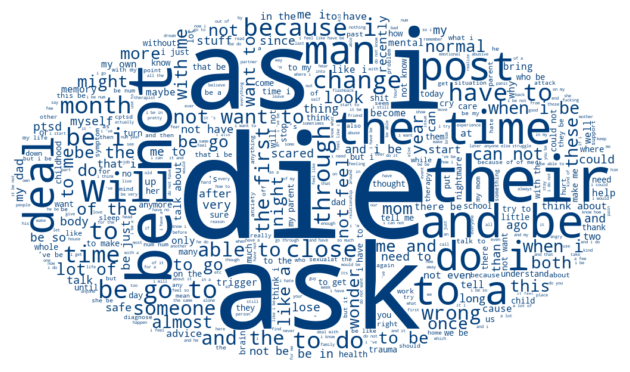

Word cloud of posts from problem suicidal


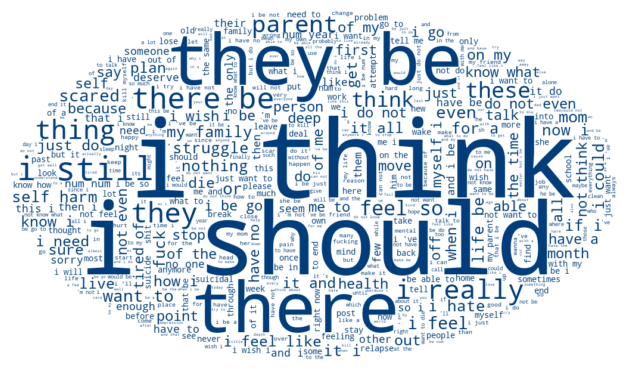

Word cloud of posts from problem eating disorder


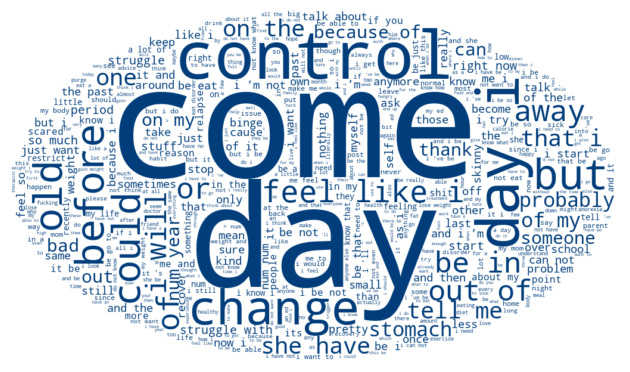

Word cloud of posts from problem depression


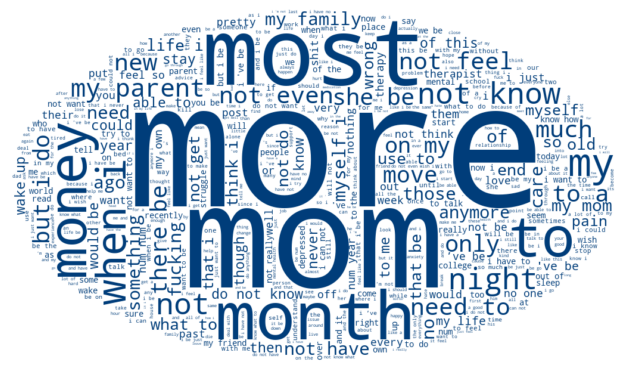

Word cloud of posts from problem anxiety


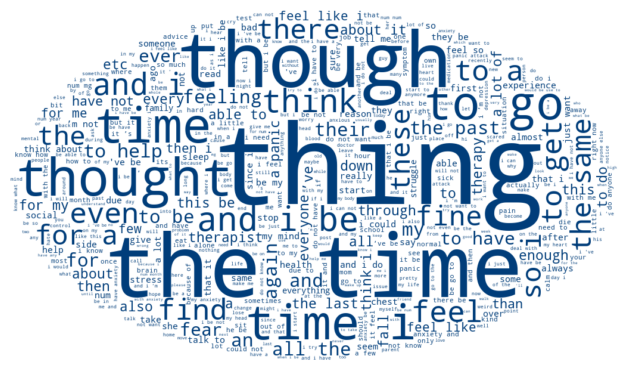

Word cloud of posts from problem bipolar


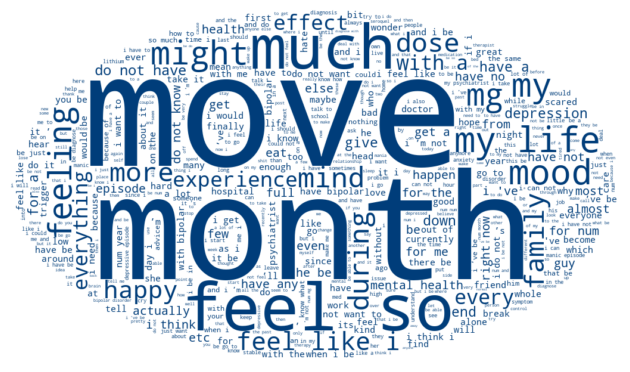

Word cloud of posts from problem schizophrenia


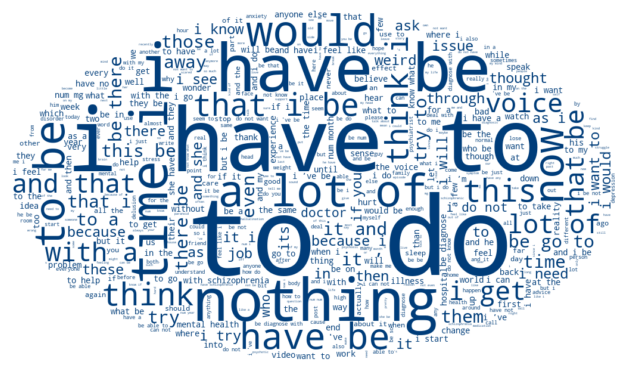

In [17]:
for syp in main_df.problem.unique():
    problem_documents = main_df[main_df['problem'] == syp]["body"]
    
    ## Apply normalize method
    problem_documents = problem_documents.apply(lambda text: normalize(text))

    ## map text abbreviation into standard words/phrase
    problem_documents = problem_documents.replace(abbrv_d,regex=True)
    problem_documents = problem_documents.to_list()
    
    print(f"Word cloud of posts from problem {syp}")
    
    problem_tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, 3),max_features=500)
    problem_text_tfidf = problem_tfidf_vectorizer.fit_transform(problem_documents)
    problem_text_tfidf= np.asarray(problem_text_tfidf.todense())
    tokens = problem_tfidf_vectorizer.get_feature_names_out()

    problem_weights = list(problem_text_tfidf[np.nonzero(problem_text_tfidf)])
    problem_word_freqs = { w:problem_weights[idx]  for (idx, w) in enumerate(tokens) }

    wc = WordCloud(color_func=color_func, 
                   background_color="white", 
                   mask=get_mask(),
                   max_words=500,
                   contour_width=0)

    wc.generate_from_frequencies(problem_word_freqs)

    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

